# Lab 4-2: Snowpack internal energy - completing the snowpack energy balance
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

In [17]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### SOS Data

In [18]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

# Replicate the steps from Lab 4-1 to create a dataset of in-snow temperature measurements (excluding snow surface temperatures)

In [19]:
tsnow_vars = [v for v in sos_dataset if 'Tsnow_' in v and v.endswith('_d')]
snow_depth_vars = ['SnowDepth_d']
print(snow_depth_vars, tsnow_vars)

['SnowDepth_d'] ['Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d']


In [20]:
# Transform the NetCDF dataset to be a "tidy" dataset of snow depths
snow_temp_dataset = sos_dataset[
    tsnow_vars + snow_depth_vars
].to_dataframe().reset_index().set_index(['time', 'SnowDepth_d']).melt(ignore_index=False)

# Calculate the depth of the snow sensor (relative to the snow surface)
# using the snow depth measurements and the known above-ground height
# of the snow sensors
snow_temp_dataset['height_agl'] = snow_temp_dataset['variable'].str[6:9].str.replace('_', '.').astype(float)
snow_temp_dataset = snow_temp_dataset.reset_index().set_index('time')
snow_temp_dataset['depth'] = snow_temp_dataset['height_agl'] - snow_temp_dataset['SnowDepth_d']

In [21]:
# remove measurements NOT in the snowpack
snow_temp_dataset = snow_temp_dataset.query("depth < 0")
snow_temp_dataset

,SnowDepth_d,variable,value,height_agl,depth
time,,,,,
2022-11-28 01:00:00,0.423657,Tsnow_0_4m_d,-9.056437,0.4,-0.023657
2022-11-28 01:30:00,0.461395,Tsnow_0_4m_d,-10.109233,0.4,-0.061395
2022-11-28 02:00:00,0.499132,Tsnow_0_4m_d,-9.103524,0.4,-0.099132
2022-11-28 02:30:00,0.536870,Tsnow_0_4m_d,-10.318118,0.4,-0.136870
2022-11-28 03:00:00,0.574608,Tsnow_0_4m_d,-11.310650,0.4,-0.174608
...,...,...,...,...,...
2023-04-09 11:00:00,1.509988,Tsnow_1_5m_d,-2.090520,1.5,-0.009988
2023-04-09 11:30:00,1.506667,Tsnow_1_5m_d,-2.059685,1.5,-0.006667
2023-04-09 12:00:00,1.503345,Tsnow_1_5m_d,-2.046416,1.5,-0.003345


# Calculate internal energy of the snowpack

From Module 4, we can estimate the change in internal energy of the snowpack with the equation

$$ \frac{d}{dt} (\Delta z U) = \rho_s c_p^{ice} \Delta z \frac{d}{dt} \langle T_s \rangle $$

where $\langle T_s \rangle$ is the depth-averaged snowpack temperature. Let's calculate this

In [22]:
# Estimate the average snowpack temperature by averaging all in-snow temperatuer measurements for each timestamp
snow_internal_energy_df = snow_temp_dataset.groupby([snow_temp_dataset.index])[['value']].mean().rename(columns={
    'value': 'snowpack_temp'
})
snow_internal_energy_df

,snowpack_temp
time,
2022-11-28 01:00:00,-9.056437
2022-11-28 01:30:00,-10.109233
2022-11-28 02:00:00,-9.103524
2022-11-28 02:30:00,-10.241496
2022-11-28 03:00:00,-11.251528
...,...
2023-05-09 05:30:00,NaN
2023-05-09 06:00:00,NaN
2023-05-09 06:30:00,NaN


For now we will estimate the density of snow as constant, let's say 300 kg/m^3.

Note we also need snow depth. Let's add that in. We will use snowpdepth measurements from tower D, because that is where we took our snow temperature measurements from. 

In [23]:
# add snow depth to our dataset
snow_internal_energy_df = snow_internal_energy_df.join(
    sos_dataset['SnowDepth_d'].to_series()
)
snow_internal_energy_df.head()

,snowpack_temp,SnowDepth_d
time,,
2022-11-28 01:00:00,-9.056437,0.423657
2022-11-28 01:30:00,-10.109233,0.461395
2022-11-28 02:00:00,-9.103524,0.499132
2022-11-28 02:30:00,-10.241496,0.536870
2022-11-28 03:00:00,-11.251528,0.574608


In [24]:
from metpy.units import units

We assume a constant value of density for the snowpack for this lab

In [25]:
rho_s = 300 * units ("kg/m^3")
c_p_ice = 2090 * units ("J/kg/K") # specific heat capacity of ice
delta_t = 30*60*units("second") # our timestep is 30 minutes

In [26]:
T_snowpack = snow_internal_energy_df['snowpack_temp'].values * units('degC')
Depth_snowpack = snow_internal_energy_df['SnowDepth_d'].values * units('meters')

Calculate the dT/dt

In [27]:
dT_dt = np.gradient(
    snow_internal_energy_df['snowpack_temp'],
    30*60
) * units('K / second')

Calculate the internal energy change term

$$ \frac{dU}{dt} = \rho_s c_p^{ice} \Delta z \frac{d}{dt} \langle T_s \rangle $$


In [28]:
dU_dt = rho_s * c_p_ice * Depth_snowpack * dT_dt

In [29]:
snow_internal_energy_df['internal_energy_change'] = dU_dt.magnitude

<Axes: xlabel='time'>

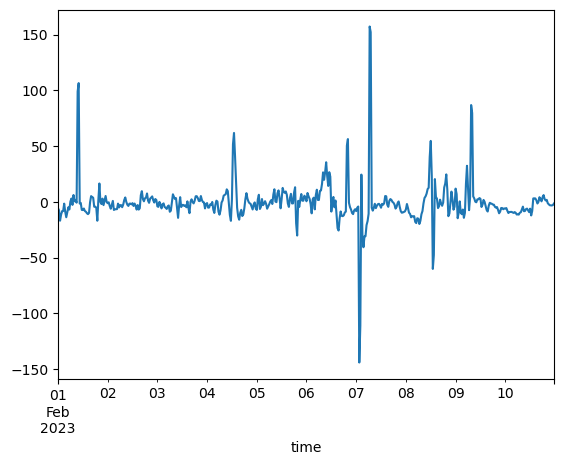

In [30]:
snow_internal_energy_df['internal_energy_change'].loc['20230201': '20230210'].plot()

# Calculating a (more) complete snowpack energy balance

Building on our results from Lab3-2, let's plot all the components of the snowpack energy balance. Remember in Lab3-2, we calculated the residual and wondered if that residual was equal to the snowpack internal energy change. Now we have an estimate of that term.

Load the saved dataset from Lab3-2. Remove the estimated "residual" as we will recalculate it.

In [31]:
energy_balance_df_diurnal_average = pd.read_pickle("../module3/energy_balance_df_diurnal_average.pkl")
energy_balance_df_diurnal_average = energy_balance_df_diurnal_average.drop(columns='residual')
energy_balance_df_diurnal_average

,net_radiation,latent_heat_flux,sensible_heat_flux,ground_heat_flux
hour_of_day,,,,
0,-35.334694,0.277639,-2.618995,-1.773447
1,-27.886284,0.232944,-2.404043,-1.773570
2,-26.339355,-0.041260,-2.927044,-1.822673
3,-24.365929,0.029141,-2.944553,-1.857791
4,-27.317818,0.102549,-3.169994,-1.855704
5,-20.569473,0.319738,-3.627988,-1.840289
6,-22.247070,0.192570,-2.994521,-1.812175
7,-22.420853,0.042563,-2.646373,-1.800731
8,-15.041748,-0.327816,-2.957748,-1.776280


Let's calculate the "diurnal cycle"/"composite" of the internal energy change term we have estimated in this lab. Remember that in Lab 3-2, we only considered data between Dec--March.

In [32]:
# Create a column representing the hour of the day
snow_internal_energy_df['hour_of_day'] = snow_internal_energy_df.index.hour

# Isolate data to Dec-Mar
# Create a column representing the hour of the day
snow_internal_energy_df = snow_internal_energy_df.loc['20221201': '20230331']

# Isolate the columns we want (i.e. remove snowdepth and snowpack temp)
snow_internal_energy_df = snow_internal_energy_df.drop(columns=['snowpack_temp', 'SnowDepth_d'])

snow_internal_energy_df

,internal_energy_change,hour_of_day
time,,
2022-12-01 22:30:00,890.630806,22
2022-12-01 23:00:00,149.353811,23
2022-12-01 23:30:00,-23.784119,23
2022-12-02 00:00:00,-151.119530,0
2022-12-02 00:30:00,-263.014894,0
...,...,...
2023-03-31 21:30:00,-0.588026,21
2023-03-31 22:00:00,2.936079,22
2023-03-31 22:30:00,3.402451,22


In [33]:
# Groupby the hour_of_day and take the median (instead of the mean, this will handle any outliers, which appear in the radiation data)
snow_internal_energy_df_diurnal_average = snow_internal_energy_df.groupby('hour_of_day').median()
snow_internal_energy_df_diurnal_average

,internal_energy_change
hour_of_day,
0,-1.771998
1,-3.694650
2,-3.647207
3,-3.160964
4,-3.425118
5,-4.232271
6,-3.177943
7,1.291401
8,7.005205


In [34]:
# Combine the two datasets
energy_balance_df_diurnal_average = energy_balance_df_diurnal_average.join(
    snow_internal_energy_df_diurnal_average['internal_energy_change']
)

Text(0, 0.5, 'Energy flux (W/m^2)')

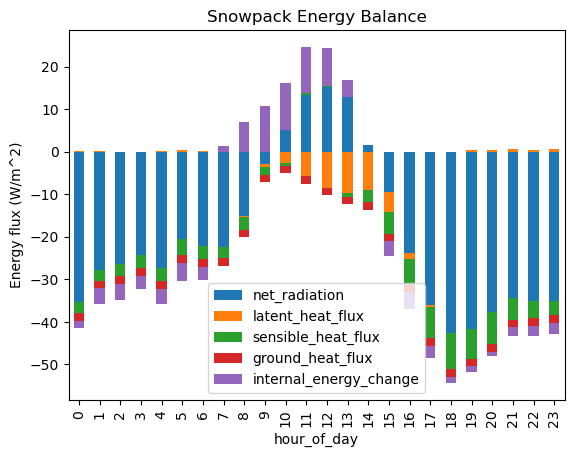

In [35]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Snowpack Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

Calculate a new estimate of the residual

In [36]:
energy_balance_df_diurnal_average['residual'] = - (
    energy_balance_df_diurnal_average['net_radiation'] 
    + energy_balance_df_diurnal_average['latent_heat_flux'] # we already negated latent heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['sensible_heat_flux'] # we already negated sensible heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['ground_heat_flux']
    + energy_balance_df_diurnal_average['internal_energy_change']
)

Did we do the math correctly? We can check by making sure the sum of all the energy balance terms is 0.

In [37]:
energy_balance_df_diurnal_average.sum(axis=1)

hour_of_day
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
dtype: float64

Text(0, 0.5, 'Energy flux (W/m^2)')

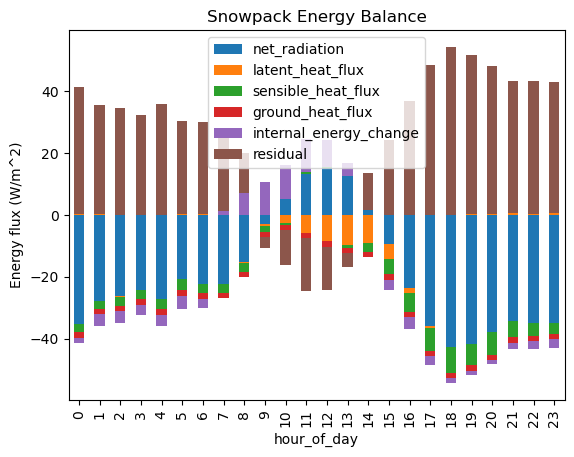

In [38]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Snowpack Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

How does this compare to our plot from Lab 3-2? Did we remove much of the "residual"